In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import pyramid_gaussian, resize

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
# --- 1. SYNTHETIC DATA GENERATION ---
# We will create a 100x100 grid to represent our world.
# Each pixel is a "grid cell" as described in your paper.
MAP_SIZE = (100, 100)

In [4]:
def create_synthetic_data(size):
    """
    Generates synthetic geospatial maps for our features and target.
    This simulates the data you would source from GEE, WDPA, etc.
    """
    print(f"Creating synthetic {size} maps...")
    
    # --- Target Variable (y) ---
    # This is our "World Database on Protected Areas (WDPA)" layer
    # 0 = Not Protected, 1 = Protected
    existing_pas = np.zeros(size)
    # Create a 30x30 "National Park" in a high-value area
    existing_pas[10:40, 10:40] = 1
    # Create a smaller 15x15 "Reserve"
    existing_pas[70:85, 10:25] = 1

    # --- Feature Variables (X) ---
    
    # Feature 1: Environmental Value (like NDVI)
    # Hypothesis: PAs are MORE likely in high-value areas.
    env_value_map = np.zeros(size)
    # The "National Park" area is a high-value hotspot
    env_value_map[5:45, 5:45] = 0.9
    # The "Reserve" area is also high-value
    env_value_map[65:90, 5:30] = 0.8
    # Add another "unprotected" hotspot (where transition risk should be high)
    env_value_map[20:40, 70:90] = 0.85
    
    # Feature 2: Economic Activity (like GDP / Night Lights)
    # Hypothesis: PAs are LESS likely in high-GDP areas (high opportunity cost).
    gdp_map = np.zeros(size)
    # Create a 25x25 "high-GDP city" where protection is unlikely
    gdp_map[50:75, 60:85] = 1.0 
    # Add some noise
    gdp_map += np.random.rand(*size) * 0.1
    
    # Feature 3: Population Density
    # Hypothesis: PAs are LESS likely in high-population areas.
    pop_map = np.zeros(size)
    # Population is high near the city
    pop_map[45:80, 55:90] = 0.8
    # Add some "villages"
    pop_map[15:25, 50:60] = 0.3
    pop_map += np.random.rand(*size) * 0.05
    
    # Return a dictionary of feature maps and the single target map
    feature_maps = {
        'env_value': env_value_map,
        'gdp': gdp_map,
        'population': pop_map
    }
    
    return feature_maps, existing_pas

In [5]:
# --- 2. PYRAMID FEATURE ENGINEERING ---

def build_pyramid_features(feature_maps, target_map):
    """
    Takes the raw maps and engineers multi-scale features using a
    Gaussian Pyramid. This is the core of the "pyramid representation".
    """
    print("Engineering pyramid features...")
    
    # This will hold all our features, one row per pixel
    features_list = []
    
    # Flatten the target map to be our 'y' variable
    # .ravel() turns a 2D map into a 1D list
    target_series = pd.Series(target_map.ravel(), name="is_protected")
    
    for name, map_data in feature_maps.items():
        # ---
        # Add the original map (Scale 0)
        # This is the pixel's own value
        # ---
        features_list.append(
            pd.Series(map_data.ravel(), name=f"{name}_scale_0")
        )
        
        # ---
        # Build a Gaussian Pyramid
        # This creates blurred, downsampled versions of the map.
        # We use `downscale=4` for more distinct scales.
        # max_layer=3 gives us 3 pyramid levels (plus scale 0).
        # ---
        pyramid = list(pyramid_gaussian(map_data, downscale=4, max_layer=3))
        
        # pyramid[0] is the original 100x100
        # pyramid[1] is 25x25 (blurred average of 4x4 blocks)
        # pyramid[2] is 7x7 (blurred average of 16x16 blocks)
        # pyramid[3] is 2x2 (blurred average of 64x64 blocks)

        # Loop through the smaller pyramid layers (starting from layer 1)
        for i, layer in enumerate(pyramid[1:], 1):
            
            # ---
            # Now we resize the small, blurred layer back up to the
            # original 100x100 size.
            # ---
            # This means every pixel now has new features:
            # - Its original value (scale 0)
            # - The average value of its 4x4 neighborhood (scale 1)
            # - The average value of its 16x16 neighborhood (scale 2)
            # - etc.
            scaled_layer = resize(
                layer, 
                MAP_SIZE, 
                anti_aliasing=True, 
                preserve_range=True
            )
            
            # Add this new multi-scale feature to our list
            features_list.append(
                pd.Series(scaled_layer.ravel(), name=f"{name}_scale_{i}")
            )
            
    # Combine all feature lists into a single DataFrame
    X = pd.concat(features_list, axis=1)
    y = target_series
    
    return X, y



In [6]:
# --- 3. MAIN EXECUTION ---
if __name__ == "__main__":
    
    # --- Step 1 & 2: Create Data and Engineer Features ---
    feature_maps, target_map = create_synthetic_data(MAP_SIZE)
    X_features, y_target = build_pyramid_features(feature_maps, target_map)

    print("\n--- Feature Engineering Complete ---")
    print(f"Total pixels (rows): {len(X_features)}")
    print(f"Total features (columns): {len(X_features.columns)}")
    print("Features created:", X_features.columns.tolist())
    
    
    # --- Step 3: Train Machine Learning Model ---
    print("\n--- 3. Training Machine Learning Model ---")
    
    # Split our pixels into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_target, test_size=0.3, random_state=42
    )
    
    # As per your paper, we'll use a Random Forest
    # This model is great at learning complex, non-linear patterns
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    
    print("Training Random Forest...")
    model.fit(X_train, y_train)
    


Creating synthetic (100, 100) maps...
Engineering pyramid features...

--- Feature Engineering Complete ---
Total pixels (rows): 10000
Total features (columns): 12
Features created: ['env_value_scale_0', 'env_value_scale_1', 'env_value_scale_2', 'env_value_scale_3', 'gdp_scale_0', 'gdp_scale_1', 'gdp_scale_2', 'gdp_scale_3', 'population_scale_0', 'population_scale_1', 'population_scale_2', 'population_scale_3']

--- 3. Training Machine Learning Model ---
Training Random Forest...


In [7]:
model

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
   # --- Step 4: Evaluate Model ---
print("\n--- 4. Model Evaluation ---")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Not Protected', 'Protected']))

# This helps answer your "Research Question 1"
print("Top 10 Most Important Features:")
importances = pd.Series(
    model.feature_importances_, 
    index=X_features.columns
).sort_values(ascending=False)
print(importances.head(10))


--- 4. Model Evaluation ---
               precision    recall  f1-score   support

Not Protected       1.00      1.00      1.00      2644
    Protected       1.00      0.99      1.00       356

     accuracy                           1.00      3000
    macro avg       1.00      1.00      1.00      3000
 weighted avg       1.00      1.00      1.00      3000

Top 10 Most Important Features:
env_value_scale_1     0.476775
env_value_scale_2     0.181364
env_value_scale_3     0.108230
env_value_scale_0     0.095401
population_scale_2    0.037809
gdp_scale_3           0.037787
population_scale_3    0.034741
gdp_scale_2           0.011515
gdp_scale_1           0.007300
population_scale_1    0.005874
dtype: float64


In [9]:
# --- Step 5: Generate "Transition Risk" Map ---
# This is the answer to your "Research Question 2"
print("\n--- 5. Generating Transition Risk Map ---")

# We use the trained model to predict the *probability*
# that *every* pixel in the world will become protected.
# We use [:, 1] to get the probability of class "1" (Protected)
all_pixels_risk_scores = model.predict_proba(X_features)[:, 1]

# Reshape the 1D list of 10,000 probabilities back into a 100x100 map
transition_risk_map = all_pixels_risk_scores.reshape(MAP_SIZE)

# We mask out areas that are *already* protected
transition_risk_map[target_map == 1] = 0

print("Prediction complete.")


--- 5. Generating Transition Risk Map ---
Prediction complete.


Generating visualizations...


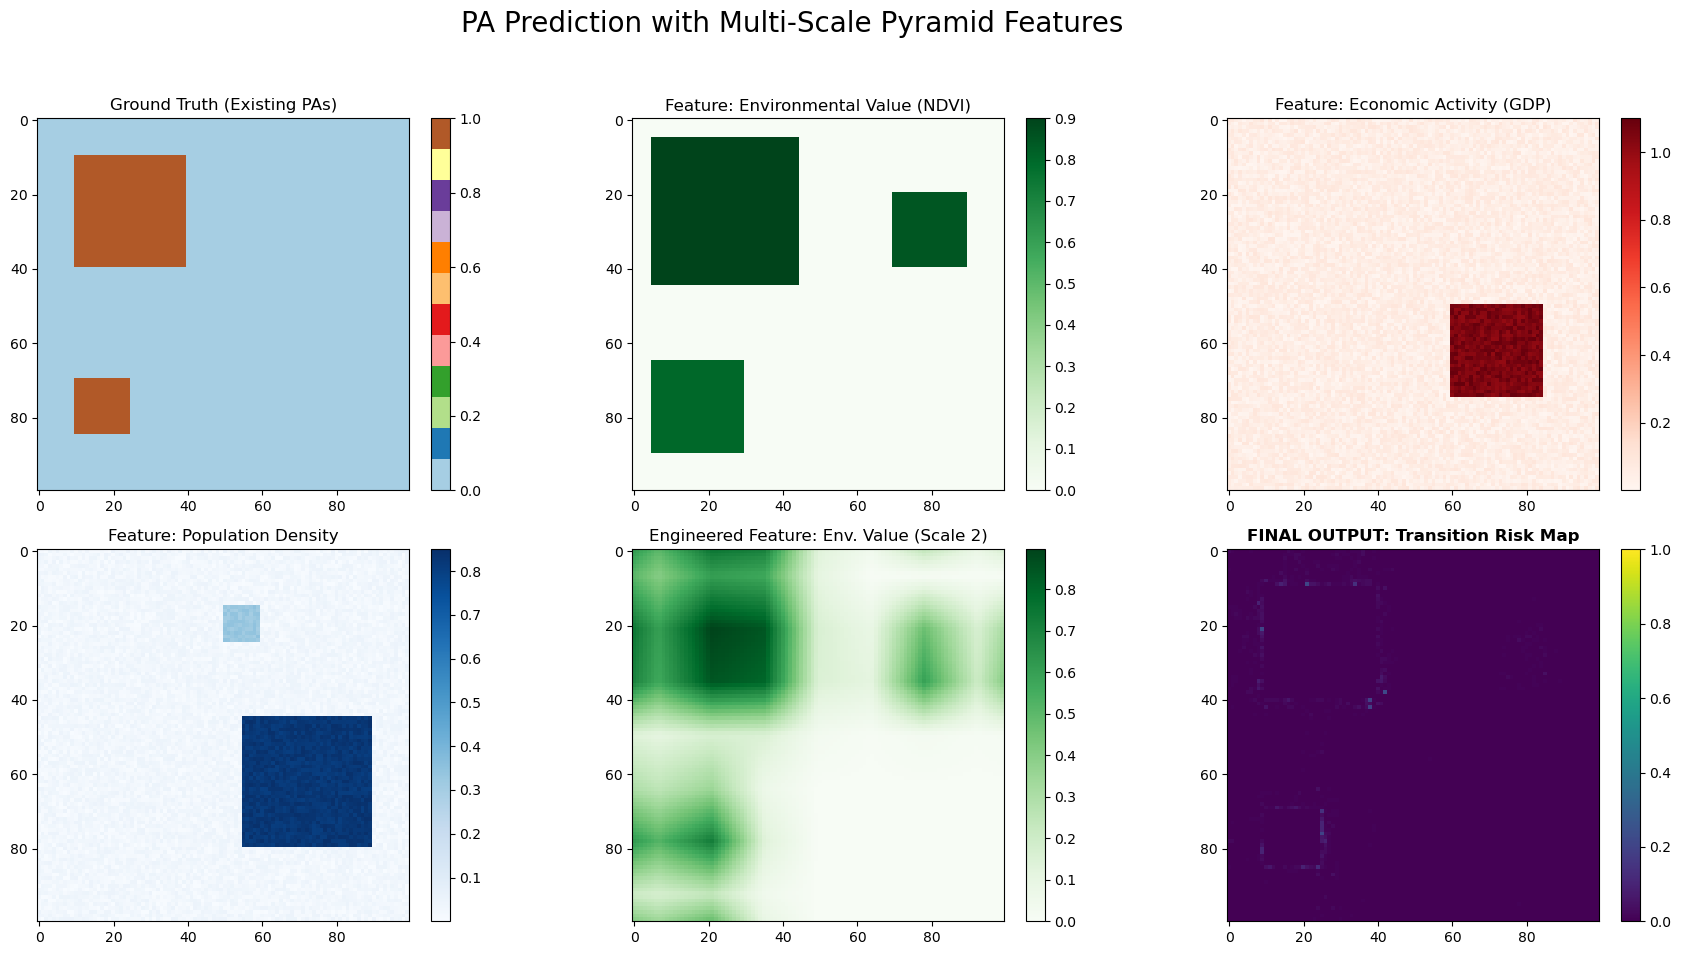

In [10]:
# --- Step 6: Visualize the Results ---
print("Generating visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('PA Prediction with Multi-Scale Pyramid Features', fontsize=20)

# Plot 1: Ground Truth
ax = axes[0, 0]
im = ax.imshow(target_map, cmap='Paired')
ax.set_title('Ground Truth (Existing PAs)')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Plot 2: Environmental Value
ax = axes[0, 1]
im = ax.imshow(feature_maps['env_value'], cmap='Greens')
ax.set_title('Feature: Environmental Value (NDVI)')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Plot 3: Economic Activity
ax = axes[0, 2]
im = ax.imshow(feature_maps['gdp'], cmap='Reds')
ax.set_title('Feature: Economic Activity (GDP)')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Plot 4: Population
ax = axes[1, 0]
im = ax.imshow(feature_maps['population'], cmap='Blues')
ax.set_title('Feature: Population Density')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Plot 5: A "Pyramid" Feature
# This is what the model "sees" at a large scale for NDVI
pyramid_feature_example = X_features['env_value_scale_2'].values.reshape(MAP_SIZE)
ax = axes[1, 1]
im = ax.imshow(pyramid_feature_example, cmap='Greens')
ax.set_title('Engineered Feature: Env. Value (Scale 2)')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Plot 6: The FINAL OUTPUT
ax = axes[1, 2]
im = ax.imshow(transition_risk_map, cmap='viridis', vmin=0, vmax=1)
ax.set_title('FINAL OUTPUT: Transition Risk Map', fontweight='bold')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()